# Home Credit Modeling

In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import iqr, randint, uniform
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import Imputer, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
import pickle
from skopt import gp_minimize
from skopt.plots import plot_convergence
import gc
from IPython.display import display

pd.options.display.max_columns = None

%load_ext autotime

gc.enable()
np.random.seed(235)

path = "/Users/dsaxton/home_credit_default/"

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.28 ms


#### Load the data

In [66]:
df = pd.read_csv(path + "train.csv")
sk_id_curr = df.pop("SK_ID_CURR")
y = df.pop("TARGET")

time: 27.5 s


#### Create scores DataFrames

In [3]:
scores_train = pd.DataFrame({"SK_ID_CURR": sk_id_curr, 
                      "TARGET": y, 
                      "LGB_SCORE": np.empty(len(df.index)), 
                      "RIDGE_SCORE": np.empty(len(df.index)), 
                      "XGB_SCORE": np.empty(len(df.index))}}, 
                     index=df.index)

time: 15.4 ms


In [64]:
df_test = pd.read_csv(path + "test.csv")
sk_id_curr = df_test.pop("SK_ID_CURR")

time: 4.02 s


In [65]:
scores_test = pd.DataFrame({"SK_ID_CURR": sk_id_curr, 
                            "TARGET": y, 
                            "LGB_SCORE": np.empty(len(df.index)), 
                            "RIDGE_SCORE": np.empty(len(df.index)), 
                            "XGB_SCORE": np.empty(len(df.index))}, 
                           index=df.index)

time: 24.4 ms


# LightGBM

#### Select features

In [50]:
clf = lgb.LGBMClassifier(n_estimators=1000, num_leaves=23, subsample=0.5)
clf.fit(df, y)

lgb_cols = df.columns[clf.feature_importances_ > 0]
len(lgb_cols)

486

time: 1min 53s


#### CV performance

In [ ]:
params = {"n_estimators": 5000, 
          "num_leaves": 500, 
          "min_data_in_leaf": 1000,
          "learning_rate": 0.005, 
          "bagging_fraction": 0.5, 
          "bagging_freq": 1, 
          "feature_fraction": 0.5, 
          "lambda_l2": 1}

to_drop = []

lgb_data = lgb.Dataset(data=df[lgb_cols].drop(to_drop, axis=1), 
                       label=y)

cv_result = lgb.cv(params=params, 
                   train_set=lgb_data, 
                   nfold=5, 
                   metrics="auc", 
                   early_stopping_rounds=200, 
                   stratified=True, 
                   shuffle=True, 
                   verbose_eval=100, 
                   show_stdv=True, 
                   seed=2357)

cv_result = pd.DataFrame(cv_result)

In [ ]:
cv_result.tail()

#### Generate out of fold predictions

In [51]:
kfold = StratifiedKFold(n_splits=3, random_state=2357)

time: 749 µs


In [ ]:
for train_indx, test_indx in kfold.split(df.values, y.values):
    lgb_model = lgb.LGBMClassifier(n_estimators=3183, 
                                   num_leaves=500, 
                                   min_data_in_leaf=1000,
                                   learning_rate=0.005, 
                                   bagging_fraction=0.5, 
                                   bagging_freq=1, 
                                   feature_fraction=0.5, 
                                   lambda_l2=1) 
    lgb_model.fit(df.loc[train_indx, lgb_cols], y.loc[train_indx])
    scores.loc[test_indx, "LGB_SCORE"] = lgb_model.predict_proba(df.loc[test_indx, lgb_cols])[:,1]

scores.head()

In [53]:
roc_auc_score(scores["TARGET"], scores["LGB_SCORE"])

0.7945808429180359

time: 81.7 ms


# Ridge Regression

#### Remove principal components

In [28]:
df_linear = df.drop([c for c in df.columns if "AGG_COMP" in c], axis=1)
df_linear.drop("FLAG_MOBIL", axis=1, inplace=True)

time: 1.47 s


#### Compute matrix of absolute correlations

In [29]:
corr_mat = df_linear.corr().abs()
corr_mat = corr_mat.where(np.triu(np.ones(corr_mat.shape).astype(np.bool), k=1))

time: 3min 30s


#### Remove highly correlated columns

In [30]:
t = 0.9
df_linear = df_linear.drop(corr_mat[corr_mat > t].dropna(axis=1, how="all").columns.tolist(), axis=1)
df_linear.shape

(307511, 376)

time: 541 ms


#### Remove columns with heavy missingness

In [31]:
m = 0.5
df_linear.drop(df_linear.isnull().mean().where(lambda x: x > m).dropna().index, axis=1, inplace=True)
df_linear.shape

(307511, 294)

time: 1.03 s


#### Remove columns with one unique value

In [32]:
df_linear.drop(df_linear.nunique().where(lambda x: x == 1).dropna().index, axis=1, inplace=True)
df_linear.shape

(307511, 287)

time: 2.23 s


#### Median impute and standardize all columns

In [33]:
impute = Imputer(strategy="median")
quant = QuantileTransformer(output_distribution="normal")
stand = StandardScaler()

time: 1.72 ms


In [34]:
scaled_df = pd.DataFrame(stand.fit_transform(quant.fit_transform(impute.fit_transform(df_linear))), 
                         columns=df_linear.columns, 
                         index=df_linear.index)
scaled_df.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,MIN_PREV_AMT_ANNUITY_24M,AVG_PREV_PROP_APPROVED_24M,MAX_PREV_PROP_APPROVED_24M,COUNT_PREV_APP,MIN_PREV_DAYS_TERMINATION,MAX_PREV_DAYS_TERMINATION,AVG_PREV_DAYS_TERMINATION,RANGE_PREV_DAYS_TERMINATION,MIN_PREV_AMT_CREDIT,MAX_PREV_AMT_CREDIT,AVG_PREV_AMT_CREDIT,MIN_PREV_AMT_CREDIT_WEIGHTED,MAX_PREV_AMT_CREDIT_WEIGHTED,AVG_PREV_AMT_CREDIT_WEIGHTED,MIN_PREV_AMT_CREDIT_DIV_ANNUITY,MAX_PREV_AMT_CREDIT_DIV_ANNUITY,AVG_PREV_AMT_CREDIT_DIV_ANNUITY,MIN_PREV_AMT_CREDIT_DIV_ANNUITY_WEIGHTED,MAX_PREV_AMT_CREDIT_DIV_ANNUITY_WEIGHTED,AVG_PREV_AMT_CREDIT_DIV_ANNUITY_WEIGHTED,MIN_PREV_AMT_ANNUITY,MAX_PREV_AMT_ANNUITY,AVG_PREV_AMT_ANNUITY,MIN_PREV_AMT_ANNUITY_WEIGHTED,AVG_PREV_AMT_ANNUITY_WEIGHTED,MIN_DAYS_DECISION,MAX_DAYS_DECISION,RANGE_DAYS_DECISION,SUM_DAYS_LAST_DUE_NULL,AVG_DAYS_LAST_DUE_NULL,AVG_PREV_RATE_DOWNPAYMENT_WEIGHTED,MAX_PREV_PROP_APPROVED_WEIGHTED,AVG_PREV_RATE_DOWNPAYMENT,AVG_PREV_PROP_APPROVED,MIN_PREV_PROP_APPROVED,SUM_PREV_URGENT_NEEDS,SUM_PREV_REPAIRS,SUM_PREV_OTHER,SUM_PREV_LIMIT_REJECT,SUM_REFUSED_CONTRACT,SUM_CANC_CONTRACT,SUM_APPR_CONTRACT,SUM_PREV_HC_REJECT,SUM_PREV_INSURE_REQ,COUNT_PREV_WALK_IN,COUNT_PREV_HIGH_YIELD,COUNT_PREV_LOW_YIELD,SUM_DAYS_LAST_DUE_1ST_VERSION_EQ_DAYS_LAST_DUE,SUM_DAYS_FIRST_DRAWING_SENTINEL_WEIGHTED,SUM_DAYS_LAST_DUE_LT_FIRST_VERSION,SUM_REFUSED_CONTRACT_6M,SUM_PRODUCT_COMBINATION_POS_HOUSE_INTEREST_12M,SUM_PRODUCT_COMBINATION_POS_MOBILE_INTEREST_12M,SUM_NAME_GOODS_CATEGORY_XNA_6M,SUM_NAME_SELLER_INDUSTRY_CSTR_6M,COUNT_NAME_CLIENT_TYPE_REPEATER_12M,COUNT_NAME_CLIENT_TYPE_NEW_12M,PREVIOUS_AGG_SYNTHETIC_TARGET,SUM_AMT_CREDIT_SUM_DEBT_DIV_DAYS_CREDIT_ENDDATE_ACTIVE_12M,SUM_CC_DEBT_6M,MAX_BUREAU_UTILIZATION_6M,COUNT_ACTIVE_6M,DAYS_REMAINING_ACTIVE,MAX_CREDIT_DAY_OVERDUE_6M,BUREAU_SUM_DEBT_DIFF_6M_12M,MAX_CNT_CREDIT_PROLONG,SUM_SUM_CURRENT_BUREAU_BALANCE,TOTAL_AMT_CREDIT_SUM_POS_DAYS,SUM_DAYS_CREDIT_ENDDATE_POS_DAYS,MIN_DAYS_CREDIT_ENDDATE,COUNT_BUREAU_RECORDS,MAX_CREDIT_DAY_OVERDUE_WEIGHTED,MAX_CREDIT_DAY_OVERDUE,SUM_INVERSE_DAYS_CREDIT,MAX_AMT_CREDIT_MAX_OVERDUE_WEIGHTED,MAX_AMT_CREDIT_MAX_OVERDUE,SUM_AMT_CREDIT_SUM_DEBT_WEIGHTED,SUM_AMT_CREDIT_SUM_DEBT,BUREAU_PROP_SUM_OVERDUE_AVG,MAX_DAYS_CREDIT_UPDATE,RANGE_DAYS_CREDIT_UPDATE,TOTAL_AMT_CREDIT_SUM_WEIGHTED,TOTAL_AMT_CREDIT_SUM,COUNT_CREDIT_CARD,COUNT_CAR_LOAN,COUNT_MORTGAGE,SUM_AMT_ANNUITY,BUREAU_AGG_SYNTHETIC_TARGET,SUM_UNDERPAYMENT_12M,SUM_UNDERPAYMENT_6M,MAX_PAYMENT_SIZE_6M,MAX_PAYMENT_SIZE_12M,MIN_PAYMENT_SIZE_6M,COUNT_UNDERPAYMENT,SUM_UNDERPAYMENT,SUM_UNDERPAYMENT_WEIGHTED,MAX_UNDERPAYMENT,AVG_PAYMENT_SIZE_WEIGHTED,AVG_PAYMENT_SIZE,MAX_PAYMENT_SIZE_WEIGHTED,MAX_PAYMENT_SIZE,MIN_PAYMENT_SIZE,SUM_PAYMENT_WEIGHTED,SUM_PAYMENT,SUM_DAYS_ENTRY_PAYMENT_GT_DAYS_INSTALMENT,MAX_DAYS_ENTRY_PAYMENT,RANGE_DAYS_ENTRY_PAYMENT,MAX_UNDERPAYMENT_6M,MAX_UNDERPAYMENT_12M,SUM_PAYMENT_6M,SUM_PAYMENT_DIFF_6M_12M,MAX_DAYS_ENTRY_PAYMENT_DIFF_DAYS_INSTALMENT_12M

time: 39.4 s


#### Get top features

In [35]:
select = SelectKBest(score_func=f_classif, k=200)
select.fit(scaled_df, y)
cols = scaled_df.columns[select.get_support()]

time: 1.65 s


In [36]:
scaled_df[cols].head()

,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,MIN_PREV_AMT_ANNUITY_24M,AVG_PREV_PROP_APPROVED_24M,MAX_PREV_PROP_APPROVED_24M,MIN_PREV_DAYS_TERMINATION,AVG_PREV_DAYS_TERMINATION,RANGE_PREV_DAYS_TERMINATION,MIN_PREV_AMT_CREDIT,MAX_PREV_AMT_CREDIT,AVG_PREV_AMT_CREDIT,MIN_PREV_AMT_CREDIT_WEIGHTED,MIN_PREV_AMT_CREDIT_DIV_ANNUITY,MAX_PREV_AMT_CREDIT_DIV_ANNUITY,AVG_PREV_AMT_CREDIT_DIV_ANNUITY,MIN_PREV_AMT_CREDIT_DIV_ANNUITY_WEIGHTED,MAX_PREV_AMT_CREDIT_DIV_ANNUITY_WEIGHTED,AVG_PREV_AMT_CREDIT_DIV_ANNUITY_WEIGHTED,MIN_PREV_AMT_ANNUITY,MAX_PREV_AMT_ANNUITY,AVG_PREV_AMT_ANNUITY,MIN_PREV_AMT_ANNUITY_WEIGHTED,MIN_DAYS_DECISION,MAX_DAYS_DECISION,RANGE_DAYS_DECISION,SUM_DAYS_LAST_DUE_NULL,AVG_DAYS_LAST_DUE_NULL,AVG_PREV_RATE_DOWNPAYMENT_WEIGHTED,MAX_PREV_PROP_APPROVED_WEIGHTED,AVG_PREV_RATE_DOWNPAYMENT,AVG_PREV_PROP_APPROVED,MIN_PREV_PROP_APPROVED,SUM_PREV_URGENT_NEEDS,SUM_PREV_REPAIRS,SUM_PREV_OTHER,SUM_PREV_LIMIT_REJECT,SUM_REFUSED_CONTRACT,SUM_CANC_CONTRACT,SUM_APPR_CONTRACT,SUM_PREV_HC_REJECT,SUM_PREV_INSURE_REQ,COUNT_PREV_WALK_IN,COUNT_PREV_HIGH_YIELD,COUNT_PREV_LOW_YIELD,SUM_DAYS_LAST_DUE_1ST_VERSION_EQ_DAYS_LAST_DUE,SUM_DAYS_FIRST_DRAWING_SENTINEL_WEIGHTED,SUM_DAYS_LAST_DUE_LT_FIRST_VERSION,SUM_REFUSED_CONTRACT_6M,SUM_PRODUCT_COMBINATION_POS_MOBILE_INTEREST_12M,SUM_NAME_GOODS_CATEGORY_XNA_6M,COUNT_NAME_CLIENT_TYPE_REPEATER_12M,COUNT_NAME_CLIENT_TYPE_NEW_12M,PREVIOUS_AGG_SYNTHETIC_TARGET,SUM_AMT_CREDIT_SUM_DEBT_DIV_DAYS_CREDIT_ENDDATE_ACTIVE_12M,SUM_CC_DEBT_6M,MAX_BUREAU_UTILIZATION_6M,COUNT_ACTIVE_6M,DAYS_REMAINING_ACTIVE,MAX_CREDIT_DAY_OVERDUE_6M,BUREAU_SUM_DEBT_DIFF_6M_12M,TOTAL_AMT_CREDIT_SUM_POS_DAYS,SUM_DAYS_CREDIT_ENDDATE_POS_DAYS,MIN_DAYS_CREDIT_ENDDATE,MAX_CREDIT_DAY_OVERDUE_WEIGHTED,MAX_CREDIT_DAY_OVERDUE,SUM_INVERSE_DAYS_CREDIT,MAX_AMT_CREDIT_MAX_OVERDUE_WEIGHTED,MAX_AMT_CREDIT_MAX_OVERDUE,SUM_AMT_CREDIT_SUM_DEBT_WEIGHTED,SUM_AMT_CREDIT_SUM_DEBT,BUREAU_PROP_SUM_OVERDUE_AVG,MAX_DAYS_CREDIT_UPDATE,RANGE_DAYS_CREDIT_UPDATE,TOTAL_AMT_CREDIT_SUM_WEIGHTED,TOTAL_AMT_CREDIT_SUM,COUNT_CREDIT_CARD,COUNT_CAR_LOAN,COUNT_MORTGAGE,SUM_AMT_ANNUITY,BUREAU_AGG_SYNTHETIC_TARGET,SUM_UNDERPAYMENT_12M,SUM_UNDERPAYMENT_6M,MAX_PAYMENT_SIZE_6M,MAX_PAYMENT_SIZE_12M,MIN_PAYMENT_SIZE_6M,COUNT_UNDERPAYMENT,SUM_UNDERPAYMENT,SUM_UNDERPAYMENT_WEIGHTED,MAX_UNDERPAYMENT,AVG_PAYMENT_SIZE,MAX_PAYMENT_SIZE,MIN_PAYMENT_SIZE,SUM_PAYMENT_WEIGHTED,SUM_PAYMENT,SUM_DAYS_ENTRY_PAYMENT_GT_DAYS_INSTALMENT,MAX_DAYS_ENTRY_PAYMENT,RANGE_DAYS_ENTRY_PAYMENT,MAX_UNDERPAYMENT_6M,MAX_UNDERPAYMENT_12M,SUM_PAYMENT_6M,MAX_DAYS_ENTRY_PAYMENT_DIFF_DAYS_INSTALMENT_12M,INSTALLMENT_AGG_SYNTHETIC_TARGET,MAX_POS_DPD,MAX_POS_DPD_DEF,MAX_CNT_INSTALMENT_FUTURE_PROD_SK_DPD_12M,POS_AGG_SYNTHETIC_TARGET,TOTAL_AMT_CREDIT_SUM_DIV_SUM_DAYS_CREDIT_ENDDATE,TOTAL_AMT_CREDIT_SUM_POS_DAYS_DIV_SUM_DAYS_CREDIT_ENDDATE_POS_DAYS,MAX_ABS_DAYS_INSTALMENT_DIV_DAYS_BIRTH,AMT_CREDIT_PLUS_AMT_INCOME_TOTAL,AMT_CREDIT_DIV_AMT_GOODS_PRICE,AMT_CREDIT_DIV_SUM_PAYMENT,AMT_CREDIT_DIV_AMT_ANNUITY,AMT_CREDIT_DIV_AVG_PREV_REQ_AMOUNT,AMT_CREDIT_DIV_MAX_PREV_REQ_AMOUNT,AVG_PAYMENT_SIZE_DIV_AMT_INCOME_TOTAL,AVG_PAYMENT_SIZE_DIV_AMT_CREDIT,SUM_REFUSED_CONTRACT_DIV_SUM_APPR_CONTRACT,MAX_PREV_REQ_AMOUNT_DIV_AMT_CREDIT,AMT_INCOME_TOTAL_DIV_DAYS_BIRTH,SUM_REQ_CREDIT_YEAR,SUM_REQ_CREDIT_QRT,SUM_REQ_CREDIT_QRT_DIV_SUM_REQ_CREDIT_YEAR,AMT_ANNUITY_DIV_DAYS_BIRTH,AMT_ANNUITY_DIV_DAYS_EMPLOYED,AMT_ANNUITY_PROD_DAYS_EMPLOYED,REGION_RATING_CLIENT_W_CITY_DIV_REGION_POPULAT

time: 400 ms


#### Fit $L_2$ Regularized Linear Model

In [37]:
clf = LogisticRegressionCV(Cs=[10**(-i) for i in range(4, 5)], 
                          fit_intercept=False, 
                          penalty="l2", 
                          solver="saga", 
                          scoring="roc_auc", 
                          n_jobs=-1, 
                          max_iter=1000, 
                          cv=StratifiedKFold(n_splits=5), 
                          random_state=2357)

clf.fit(scaled_df, y)
clf.scores_

{1: array([[0.77013779],
        [0.77209963],
        [0.76543276],
        [0.77115503],
        [0.77174943]])}

time: 6min 32s


In [38]:
clf.C_

array([0.0001])

time: 2.47 ms


#### Generate out of fold predictions

In [45]:
kfold = StratifiedKFold(n_splits=3)

time: 2.45 ms


In [46]:
for train_indx, test_indx in kfold.split(df.values, y.values):
    linear_model = LogisticRegression(C=0.0001, 
                                  fit_intercept=False, 
                                  penalty="l2", 
                                  solver="saga", 
                                  n_jobs=-1)
    
    scaled_train = pd.DataFrame(stand.fit_transform(quant.fit_transform(impute.fit_transform(df.loc[train_indx, cols]))), 
                                columns=df.loc[train_indx, cols].columns, 
                                index=df.loc[train_indx, cols].index)
    
    scaled_test = pd.DataFrame(stand.transform(quant.transform(impute.transform(df.loc[test_indx, cols]))), 
                                columns=df.loc[test_indx, cols].columns, 
                                index=df.loc[test_indx, cols].index)
    
    linear_model.fit(scaled_train, y.loc[train_indx])
    scores.loc[test_indx, "RIDGE_SCORE"] = linear_model.predict_proba(scaled_test)[:,1]

scores.head()

,SK_ID_CURR,TARGET,LGB_SCORE,RIDGE_SCORE
0,100002,1,4.940656e-324,0.612115
1,100003,0,0.000000e+00,0.373930
2,100004,0,0.000000e+00,0.485876
3,100006,0,0.000000e+00,0.535189
4,100007,0,0.000000e+00,0.500323


time: 1min 35s


# XGBoost

In [67]:
dmatrix = xgb.DMatrix(data=df, 
                     label=y, 
                     missing=np.nan, 
                     feature_names=df.columns)

time: 4.5 s


In [68]:
d = {
    "n_estimators": 20000, 
    "max_depth": 11, 
    "learning_rate": 0.01, 
    "subsample": 0.5, 
    "colsample_bytree": 0.5, 
    "reg_lambda": 0.01
}

cv_result = xgb.cv(params=d, 
                   dtrain=dmatrix, 
                   nfold=5, 
                   folds=StratifiedKFold(n_splits=5), 
                   early_stopping_rounds=200, 
                   metrics="auc", 
                   as_pandas=True, 
                   verbose_eval=100, 
                   show_stdv=True, 
                   seed=2357)

cv_result.tail()

KeyboardInterrupt: 

time: 1min 52s


# Random Forest

In [ ]:
clf = RandomForestClassifier(n_estimators=1000, 
                             min_samples_leaf=500, 
                             bootstrap=True, 
                             n_jobs=-1, 
                             random_state=2357)

cv_scores = cross_val_score(estimator=clf, 
                            X=impute.fit_transform(df.replace([-np.inf, np.inf], np.nan)), 
                            y=y, 
                            scoring="roc_auc", 
                            verbose=100, 
                            cv=StratifiedKFold(n_splits=5))

cv_scores.mean()

# Extra Trees

In [ ]:
impute = Imputer(strategy="median")

* 0.7417537526124696: `n_estimators=100`, `min_samples_leaf=500`
* 0.743942783926357: using `lgb_cols`

In [ ]:
clf = ExtraTreesClassifier(n_estimators=100, 
                          min_samples_leaf=500, 
                          criterion="entropy", 
                          bootstrap=True, 
                          n_jobs=-1, 
                          random_state=2357)

cv_scores = cross_val_score(estimator=clf, 
                            X=impute.fit_transform(df[lgb_cols].replace([-np.inf, np.inf], np.nan)), 
                            y=y, 
                            scoring="roc_auc", 
                            verbose=100, 
                            cv=StratifiedKFold(n_splits=5))

cv_scores.mean()

# Find Optimal Linear Combination of Scores

In [57]:
%%capture
def objective(params):
    s = params[0] * scores["LGB_SCORE"] + \
        params[1] * scores["RIDGE_SCORE"]
    
    return - roc_auc_score(scores["TARGET"], s)

space = [(0.0, 1.0), (0.0, 1.0)]

result = gp_minimize(objective, space, n_calls=200, random_state=0)

time: 3min 52s


Weights

In [58]:
result.x / np.sum(result.x)

array([0.98965977, 0.01034023])

time: 2.94 ms


AUC

In [59]:
- result.fun

0.7946036853675551

time: 5.45 ms


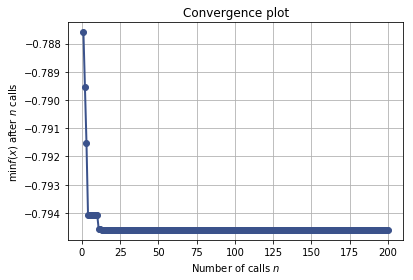

time: 158 ms


In [61]:
plot_convergence(result)

#### Score test data and generate submission

In [ ]:
df = pd.read_csv(path + "test.csv")

In [ ]:
submission = pd.DataFrame({"SK_ID_CURR": df["SK_ID_CURR"], 
                           "TARGET": lgb_model.predict_proba(df[lgb_cols])[:,1]})

submission.head()

In [ ]:
submission.to_csv(path + "submission.csv", index=False)